# Convolutional Neural Network Implementation

Theory: https://polarized-diagram-5e5.notion.site/Convolutional-Neural-Networks-1661861d4efa8044ae12f823a9b06ec9

## Deep CNN Architecture:
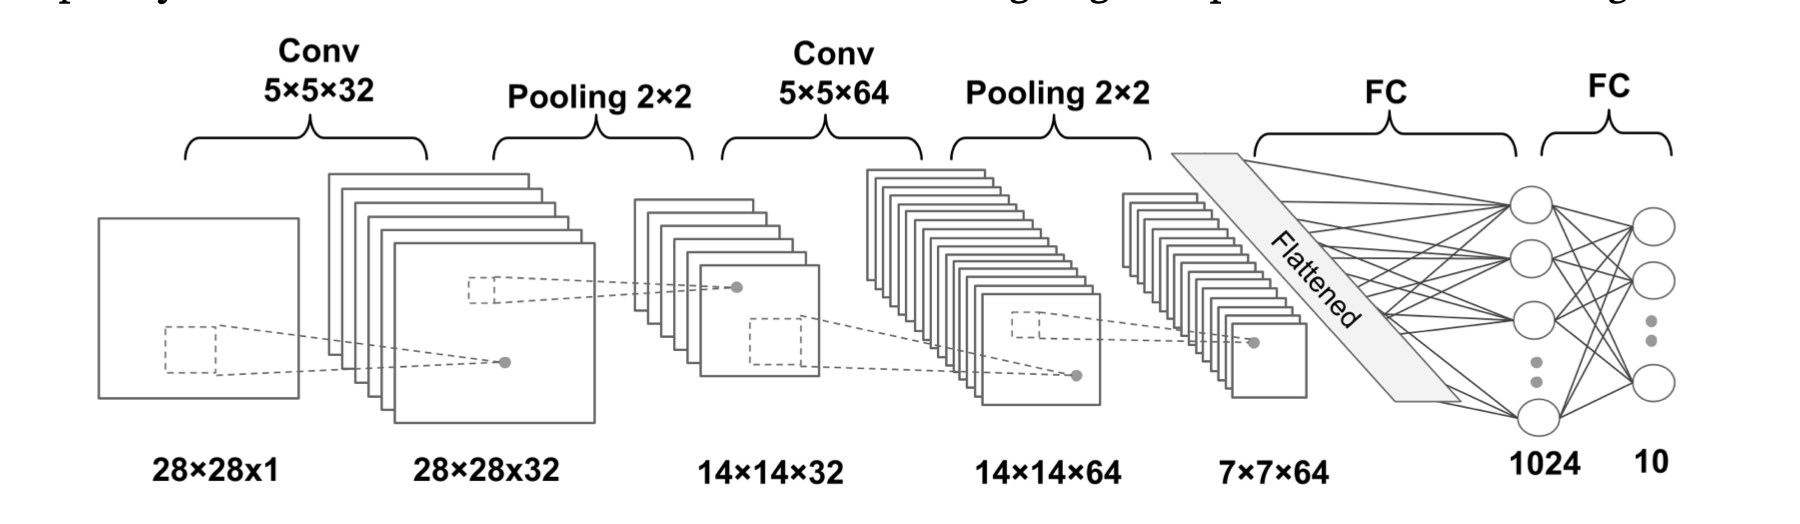

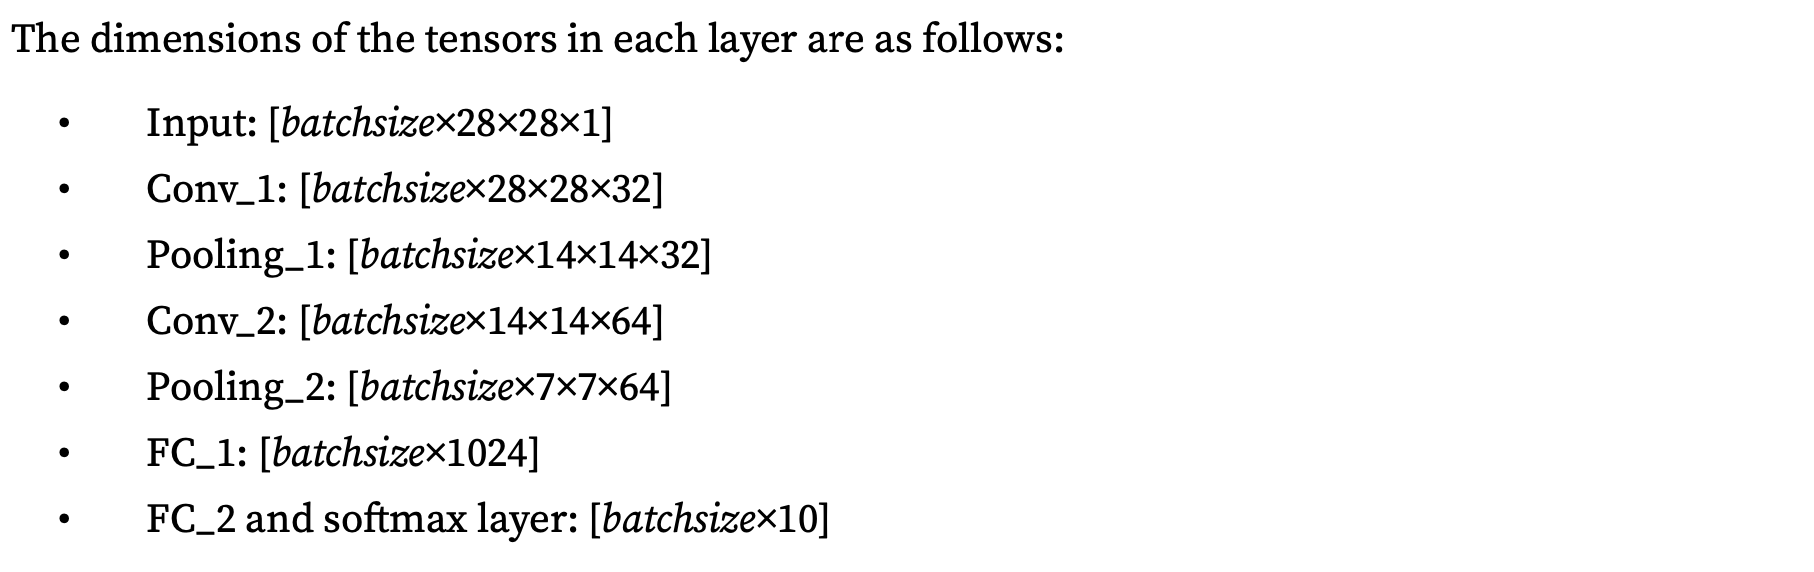

## Loading and preprocessing the data

In [1]:
import torchvision
import torch
from torchvision import transforms

image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [2]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)


## Implementing a CNN using the torch.nn module

In [10]:
# Define the model class
from torch import nn

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(3136, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 10)
        )
    def forward(self, x):
        return self.layers(x)

### Sequential API-Based Model Creation
[Start]

In [5]:
from torch import nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('maxpool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('maxpool2', nn.MaxPool2d(kernel_size=2))

In [6]:
# Analyzing the shape of the feature maps
x = torch.ones((4,1,28,28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [7]:
model.add_module('flatten', nn.Flatten())
x = torch.ones((4,1,28,28))
model(x).shape

torch.Size([4, 3136])

In [8]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

[End]

In [15]:
# change device to mps
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [16]:
model = CNNModel()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Model Training

In [17]:
from typing import List, Tuple


def train(model : CNNModel, num_epochs: int, train_dl: DataLoader, valid_dl: DataLoader) -> Tuple[List[float], List[float], List[float], List[float]]:
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for batch in train_dl:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().item()
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for batch in valid_dl:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().item()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f"Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}")

    return loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid    

In [18]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9496 val_accuracy: 0.9781
Epoch 2 accuracy: 0.9852 val_accuracy: 0.9852
Epoch 3 accuracy: 0.9896 val_accuracy: 0.9866
Epoch 4 accuracy: 0.9920 val_accuracy: 0.9890
Epoch 5 accuracy: 0.9934 val_accuracy: 0.9905
Epoch 6 accuracy: 0.9946 val_accuracy: 0.9918
Epoch 7 accuracy: 0.9951 val_accuracy: 0.9897
Epoch 8 accuracy: 0.9961 val_accuracy: 0.9893
Epoch 9 accuracy: 0.9962 val_accuracy: 0.9886
Epoch 10 accuracy: 0.9978 val_accuracy: 0.9916
Epoch 11 accuracy: 0.9971 val_accuracy: 0.9907
Epoch 12 accuracy: 0.9970 val_accuracy: 0.9909
Epoch 13 accuracy: 0.9973 val_accuracy: 0.9895
Epoch 14 accuracy: 0.9979 val_accuracy: 0.9905
Epoch 15 accuracy: 0.9979 val_accuracy: 0.9898
Epoch 16 accuracy: 0.9978 val_accuracy: 0.9910
Epoch 17 accuracy: 0.9980 val_accuracy: 0.9912
Epoch 18 accuracy: 0.9985 val_accuracy: 0.9928
Epoch 19 accuracy: 0.9986 val_accuracy: 0.9908
Epoch 20 accuracy: 0.9983 val_accuracy: 0.9917


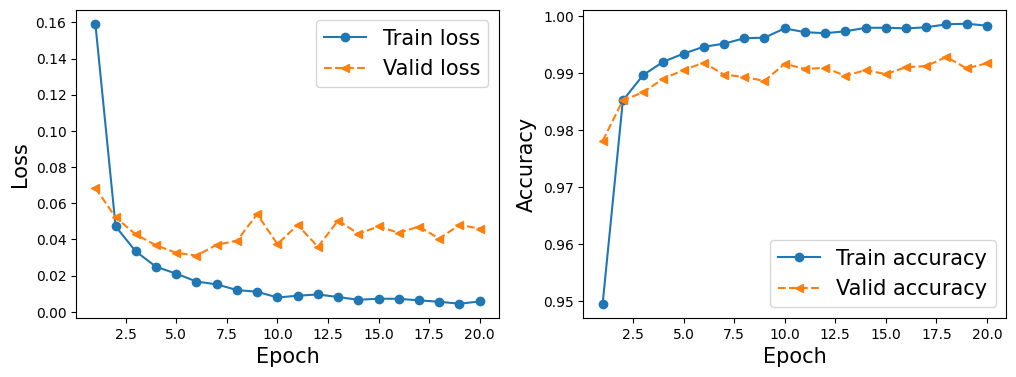

In [21]:
# Visualizing the training process
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[2], '--<', label='Valid loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[1], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<', label='Valid accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

## Evaluate the model on Test dataset

In [24]:
pred = model(mnist_test_dataset.data.unsqueeze(1).to(device) / 255.0)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets.to(device)).float()
print(f"Test accuracy: {is_correct.mean():.4f}")

Test accuracy: 0.9925


## Predict labels in the form of class-membership

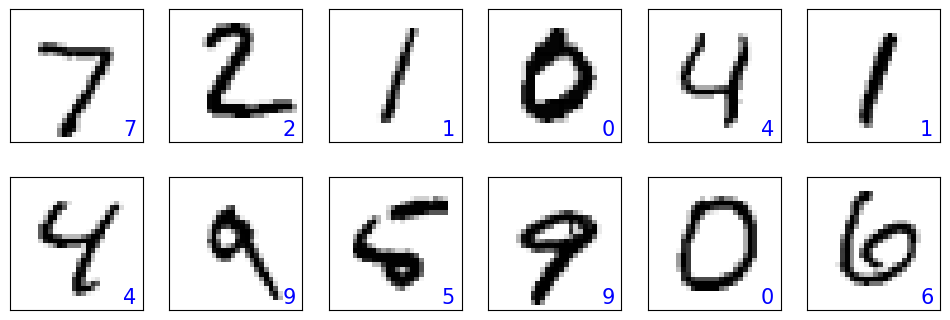

In [25]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0,:,:]
    pred = model(img.unsqueeze(0).unsqueeze(1).to(device))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), size=15, color='blue', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()
